In [1]:
import pandas as pd
import datetime

In [2]:
path = '/home/filtheo/tetra_product/data/m5_main'

calendar = pd.read_csv(f'{path}/calendar.csv')
prices = pd.read_csv(f'{path}/sell_prices.csv')
sales = pd.read_csv(f'{path}/sales_train_validation.csv')

In [3]:
# Moving to the calendar
calendar['date'] = pd.to_datetime(calendar['date'])

In [4]:
# will keep only a specific store and only food cat id
food_sales = sales[sales['cat_id'] == 'FOODS']

food_sales.groupby('store_id').agg({'item_id':'nunique'})


,item_id
store_id,
CA_1,1437
CA_2,1437
CA_3,1437
CA_4,1437
TX_1,1437
TX_2,1437
TX_3,1437
WI_1,1437
WI_2,1437


In [5]:
# same total items. Which has the most sales
food_sales.groupby('store_id').sum().iloc[:,5:].sum(axis=1)

/tmp/ipykernel_2658/4149135675.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  food_sales.groupby('store_id').sum().iloc[:,5:].sum(axis=1)


store_id
CA_1    5368154
CA_2    3472038
CA_3    7500283
CA_4    2813878
TX_1    3770176
TX_2    5003314
TX_3    4153852
WI_1    3433530
WI_2    4760570
WI_3    4717553
dtype: int64

In [6]:
# I ll take TX_2
food_sales_filtered = food_sales[food_sales['store_id'] == 'TX_2']

# Keeping only the item_id and the sales
to_drop = ['id', 'dept_id', 'cat_id', 'store_id', 'state_id']
food_sales_filtered = food_sales_filtered.drop(to_drop, axis=1).set_index('item_id')

food_sales_filtered.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001,0,0,1,2,0,4,0,0,2,2,...,3,0,1,0,0,0,0,0,1,0
FOODS_1_002,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_1_003,0,2,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2,0
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FOODS_1_005,1,1,0,2,1,1,0,2,2,2,...,2,1,1,2,1,0,2,1,2,1


In [7]:
# Move to price
prices = prices[prices['store_id'] == 'TX_2']

prices = prices[prices['item_id'].isin(food_sales_filtered.index)].drop('store_id', axis=1)
prices['sell_price'] = prices['sell_price'].astype(float)

In [8]:
# A dictionary for date_indexing
date_dict = calendar[['date', 'd']].set_index('d').to_dict()['date']

# Use the date dict to convert columns in the main df. Columns have the key as name
food_sales_filtered = food_sales_filtered.rename(columns=date_dict)

In [9]:
# merge prices with calendar
covariates = pd.merge(prices, calendar, on ='wm_yr_wk')

In [10]:
# Keep only the relevant columns -> droping seasonal columns as I will have them automaticaly from seasonal features
to_drop = ['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'snap_CA','snap_WI', 'event_name_1', 'event_name_2', ]
covariates = covariates.drop(to_drop, axis=1)

# rename snap_TX to snap
covariates = covariates.rename(columns={'snap_TX':'snap', 'item_id':'unique_id'})

<Axes: >

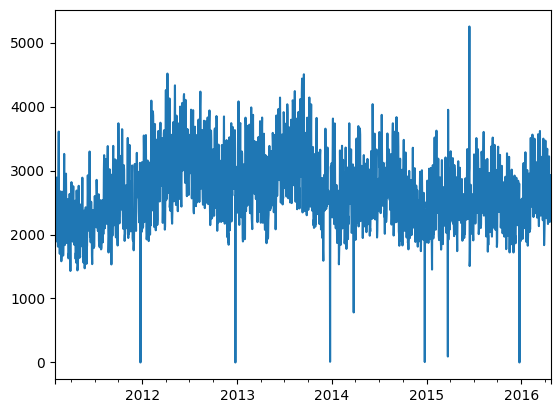

In [11]:
food_sales_filtered.sum(axis = 0).plot()

In [12]:
# I will keep data from a total of 2 years to mimick the situation we have
total_days = 365*2

# I will keep the last 2 years
food_sales_filtered = food_sales_filtered.iloc[:,-total_days:]

<Axes: >

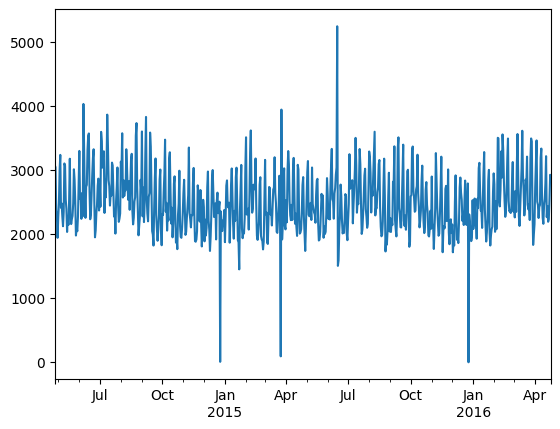

In [13]:
food_sales_filtered.sum(axis = 0).plot()

In [14]:
# Transpose the food sales to have the same format as the covariates
food_sales_filtered = food_sales_filtered.reset_index().rename(columns = {'item_id':'unique_id'})
food_sales_filtered = pd.melt(food_sales_filtered, id_vars='unique_id', var_name='date', value_name='y')

In [15]:
# merge 
out_df = pd.merge(food_sales_filtered, covariates, on = ['unique_id', 'date'], how = 'left')
out_df

,unique_id,date,y,sell_price,event_type_1,event_type_2,snap
0,FOODS_1_001,2014-04-26,2,2.24,NaN,NaN,0.0
1,FOODS_1_002,2014-04-26,0,8.88,NaN,NaN,0.0
2,FOODS_1_003,2014-04-26,0,2.88,NaN,NaN,0.0
3,FOODS_1_004,2014-04-26,16,1.78,NaN,NaN,0.0
4,FOODS_1_005,2014-04-26,0,3.28,NaN,NaN,0.0
...,...,...,...,...,...,...,...
1049005,FOODS_3_823,2016-04-24,0,2.98,NaN,NaN,0.0
1049006,FOODS_3_824,2016-04-24,1,2.48,NaN,NaN,0.0
1049007,FOODS_3_825,2016-04-24,1,3.98,NaN,NaN,0.0
1049008,FOODS_3_826,2016-04-24,1,1.28,NaN,NaN,0.0


In [17]:
# Will keep a total of 2 months as the validation set which I will use to test the system
validation_days = 30*2
real_validation_days = out_df['date'].unique()[-validation_days:]
real_validation_days

array(['2016-02-25T00:00:00.000000000', '2016-02-26T00:00:00.000000000',
       '2016-02-27T00:00:00.000000000', '2016-02-28T00:00:00.000000000',
       '2016-02-29T00:00:00.000000000', '2016-03-01T00:00:00.000000000',
       '2016-03-02T00:00:00.000000000', '2016-03-03T00:00:00.000000000',
       '2016-03-04T00:00:00.000000000', '2016-03-05T00:00:00.000000000',
       '2016-03-06T00:00:00.000000000', '2016-03-07T00:00:00.000000000',
       '2016-03-08T00:00:00.000000000', '2016-03-09T00:00:00.000000000',
       '2016-03-10T00:00:00.000000000', '2016-03-11T00:00:00.000000000',
       '2016-03-12T00:00:00.000000000', '2016-03-13T00:00:00.000000000',
       '2016-03-14T00:00:00.000000000', '2016-03-15T00:00:00.000000000',
       '2016-03-16T00:00:00.000000000', '2016-03-17T00:00:00.000000000',
       '2016-03-18T00:00:00.000000000', '2016-03-19T00:00:00.000000000',
       '2016-03-20T00:00:00.000000000', '2016-03-21T00:00:00.000000000',
       '2016-03-22T00:00:00.000000000', '2016-03-23

In [18]:
# Will keep a total of 2 months as the validation set which I will use to test the system
validation_days = 30*2
real_validation_days = out_df['date'].unique()[-validation_days:]

In [19]:
# So we need to cut 4 days so the week starts on Monday and train ends on Sunday
validation_days = 30*2 - 4 # made the adjustment
real_validation_days = out_df['date'].unique()[-validation_days:]

In [20]:
validation_df = out_df[out_df['date'].isin(real_validation_days)]
train_df = out_df[~out_df['date'].isin(real_validation_days)]

In [22]:
# Save 
path = '/home/filtheo/Cloud-for-AI-VIVES/data/m5_main'

train_df.to_csv(f'{path}/m5_train_df.csv', index=False)
validation_df.to_csv(f'{path}/m5_validation_df.csv', index=False)
